In [21]:
!pip install tf2onnx


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tf2onnx


In [23]:
# Load dataset
df = pd.read_csv("/content/squat_exercise_cleaned.csv")

# Drop unnecessary columns
df_cleaned = df.drop(columns=["Timestamp", "Subject_ID"])


In [24]:
# Encode labels
label_encoder = LabelEncoder()
squat_type_encoder = LabelEncoder()

df_cleaned['Label'] = label_encoder.fit_transform(df_cleaned['Label'])
df_cleaned['Squat_Type'] = squat_type_encoder.fit_transform(df_cleaned['Squat_Type'])


In [25]:
# Optional: Feedback map
squat_feedback_map = df[['Squat_Type', 'Feedback_Message']].drop_duplicates().set_index('Squat_Type')['Feedback_Message'].to_dict()
df_cleaned['Feedback_Message'] = df['Squat_Type'].map(squat_feedback_map)


In [26]:
# Feature and target split
X = df_cleaned.drop(columns=['Label', 'Squat_Type', 'Feedback_Message'])
y = df_cleaned['Label']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [27]:
# Time-aware split (80%-20%)
split_index = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:split_index], X_scaled[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [28]:
# MLP model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=16, callbacks=[early_stop], verbose=1)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5925 - loss: 0.6698 - val_accuracy: 0.6349 - val_loss: 0.6349
Epoch 2/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6673 - loss: 0.6214 - val_accuracy: 0.6657 - val_loss: 0.6173
Epoch 3/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6668 - loss: 0.6234 - val_accuracy: 0.6760 - val_loss: 0.6059
Epoch 4/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6669 - loss: 0.6007 - val_accuracy: 0.6891 - val_loss: 0.6017
Epoch 5/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6834 - loss: 0.5939 - val_accuracy: 0.6906 - val_loss: 0.6002
Epoch 6/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6942 - loss: 0.5845 - val_accuracy: 0.6994 - val_loss: 0.5844
Epoch 7/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7165 - loss: 0.5677 - val_accuracy: 0.7053 - val_loss: 0.5829
Epoch 8/50
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7129 - loss: 0.5694 - val_accuracy: 0.7111 - v

In [29]:
# Predict and evaluate
y_pred = (model.predict(X_test) > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.8194607268464243

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.86      0.82       408
           1       0.86      0.78      0.82       445

    accuracy                           0.82       853
   macro avg       0.82      0.82      0.82       853
weighted avg       0.82      0.82      0.82       853



In [30]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\n Model Test Accuracy: {accuracy*100:.2f}%\n")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8111 - loss: 0.3953 

 Model Test Accuracy: 81.95%



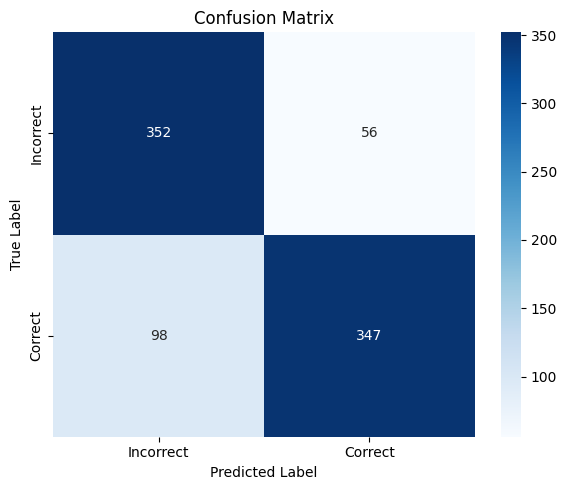

In [31]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Incorrect', 'Correct']
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [32]:
import tf2onnx
import tensorflow as tf

# إعداد input_signature
input_signature = [tf.TensorSpec([None, X_train.shape[1]], tf.float32, name="input")]

# لف الموديل داخل tf.function
@tf.function(input_signature=input_signature)
def model_func(x):
    return model(x)

# التحويل إلى ONNX
onnx_model, _ = tf2onnx.convert.from_function(
    model_func,
    input_signature=input_signature,
    opset=13,
    output_path="squat_mlp_model.onnx"
)

print("✅ ONNX model saved as 'squat_mlp_model.onnx'")


ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7bc5cc9d53a0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


✅ ONNX model saved as 'squat_mlp_model.onnx'
